In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import time
import pyvista as pv
from EDITED_aux_functions_time import *
from WarpPINN import WarpPINN
from skimage import measure
import meshio
import vtk
import time
from tqdm import tqdm
import cv2
import tetgen
from skimage.measure import label, regionprops
import pandas as pd
from scipy.ndimage import map_coordinates
import tensorflow as tf


In [2]:
patients = os.listdir('ACDC_raw/database/training')
patients.remove('.ipynb_checkpoints')
patients.sort()
idx_pt = 0
patient = patients[idx_pt]
data_path = os.path.join( 'ACDC_raw/database/training', patient)

imt_path = glob.glob(f'{data_path}/*4d.nii.gz')[0]
imt_data = nib.load(imt_path)
imt = imt_data.get_fdata()
header = imt_data.header

In [3]:
patient_no = patient[7:]

In [4]:
patient_no

'001'

In [5]:
data_path

'ACDC_raw/database/training/patient001'

In [6]:
# Pixel spacing of image
pix_dim = header['pixdim']
pixsp_x = pix_dim[1]
pixsp_y = pix_dim[2]
pixsp_z = pix_dim[3]

In [7]:
imt = np.transpose(imt, [3, 2, 1, 0])

In [8]:
frames = imt.shape[0]
slices = imt.shape[1]

In [9]:
segm_imt_path = glob.glob(f'{data_path}/*frame01_gt.nii*')[0]
segm_imt_data = nib.load(segm_imt_path)
segm_imt = segm_imt_data.get_fdata()
segm_header = segm_imt_data.header
dim = segm_header['dim']
dims = segm_imt.shape
mask_pixdim = segm_header['pixdim']

In [10]:
mask_pixdim

array([ 1.    ,  1.5625,  1.5625, 10.    ,  1.    ,  1.    ,  1.    ,
        1.    ], dtype=float32)

In [11]:
# Create a binary mask
low = 1.5 #
high = 3
mask = np.zeros(dims)
mask[(segm_imt > low) & (segm_imt < high)] = 1

In [12]:
slices

10

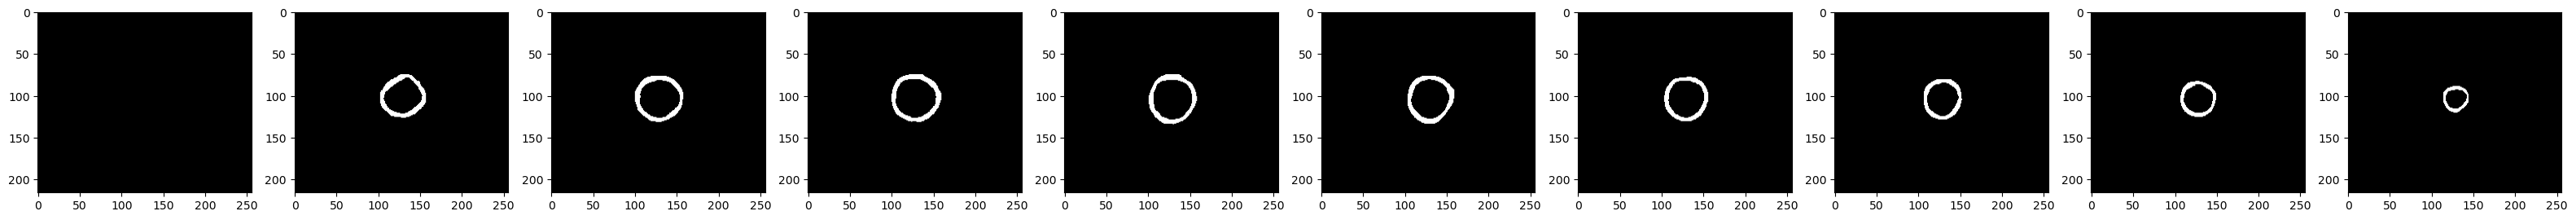

In [13]:
fig,ax = plt.subplots(1, slices, figsize=(40,40))
for i in range(slices):
    ax[i].imshow(mask[:, :, i], cmap='gray')

In [14]:
c = 0
img = mask[:, :, c]
labeled_img = label(img)
regions = regionprops(labeled_img)

if len(regions) == 0:
   c=1 
   img = mask[:, :, c]
   labeled_img = label(img)
   regions = regionprops(labeled_img)
   

myocardium_region = max(regions, key=lambda x: x.area)

# bounding box of myo
min_x, min_y, max_x, max_y = myocardium_region.bbox

# expand bounding box 20 pix in each direction if possible
buffer = 5 
min_x = max(0, min_x - buffer)
min_y = max(0, min_y - buffer)
max_x = min(img.shape[0], max_x + buffer)
max_y = min(img.shape[1], max_y + buffer)


for i in range(c+1,dims[2]): 
    img = mask[:, :, i]
    labeled_img = label(img)
    regions = regionprops(labeled_img)
    
    if len(regions) == 0:
       continue
    
    myocardium_region = max(regions, key=lambda x: x.area)

    # bounding box of myo
    minr, minc, maxr, maxc = myocardium_region.bbox
    

    # expand bounding box 20 pix in each direction if possible
    minr = max(0, minr - buffer)
    minc = max(0, minc - buffer)
    maxr = min(img.shape[0], maxr + buffer)
    maxc = min(img.shape[1], maxc + buffer)
    
    if minr < min_x:
        min_x = minr
    if maxr > max_x:
        max_x = maxr
    if minc < min_y:
        min_y = minc
    if maxc > max_y:
        max_y = maxc

In [15]:
def round_to_even(number):
    rounded_number = round(number)
    if rounded_number % 2 != 0:  # Check if the number is odd
        rounded_number += 1     # Increment by 1 to make it even
    return rounded_number

In [16]:
crop_x_in = round_to_even(min_x)
crop_x_end = round_to_even(max_x)
crop_y_in = round_to_even(min_y)
crop_y_end = round_to_even(max_y)

crop_str = str(crop_x_in)+'_'+str(crop_x_end)+'_'+str(crop_y_in)+'_'+str(crop_y_end)

In [17]:
crop_str

'70_140_96_166'

In [18]:
imt = imt[:, :, crop_y_in:crop_y_end, crop_x_in:crop_x_end].astype(np.float32)

# Reference image is the first time in the stack

imr = imt[0, :, :, :]

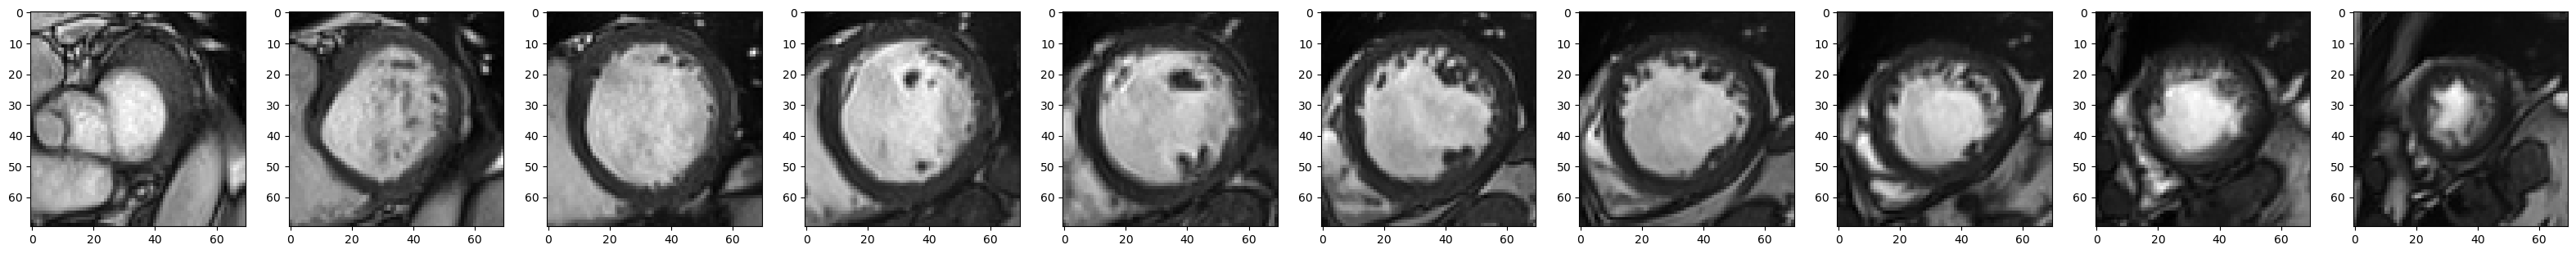

In [19]:
fig,ax = plt.subplots(1, slices, figsize=(40,40))
for i in range(slices):
    ax[i].imshow(imr[i, :, :], cmap='gray')

In [20]:
"""
pad_mask = np.pad(mask, ((0, 0), (0, 0), (1, 1)), mode='constant')

fig,ax = plt.subplots(1, 12, figsize=(40,40))
for i in range(12):
    ax[i].imshow(pad_mask[:, :, i], cmap='gray')
"""

"\npad_mask = np.pad(mask, ((0, 0), (0, 0), (1, 1)), mode='constant')\n\nfig,ax = plt.subplots(1, 12, figsize=(40,40))\nfor i in range(12):\n    ax[i].imshow(pad_mask[:, :, i], cmap='gray')\n"

In [21]:
Nx = dim[1]
Ny = dim[2]
Nz = dim[3]

xp = np.arange(Nx)
yp = np.arange(Ny)
zp = np.arange(Nz)

Y, Z, X = np.meshgrid(yp, zp, xp)

X = X[:, crop_y_in:crop_y_end, crop_x_in:crop_x_end]
Y = Y[:, crop_y_in:crop_y_end, crop_x_in:crop_x_end]
Z = Z[:, crop_y_in:crop_y_end, crop_x_in:crop_x_end]

X = X.ravel()[:,None]
Y = Y.ravel()[:,None]
Z = Z.ravel()[:,None]

# Pixel coordinates in a list
im_pix = np.hstack((X, Y, Z))
im_mesh = pixel_to_mesh(im_pix, pixsp_x, pixsp_y, pixsp_z)

In [22]:
# Generating the surface_mesh using marching cubes

# Define scaling factors for each axis
scale_x = mask_pixdim[1] # Example scaling factor for the x-axis
scale_y = mask_pixdim[2] # Example scaling factor for the y-axis
scale_z = mask_pixdim[3] # Example scaling factor for the z-axis

vertices, triangles, norm, val = measure.marching_cubes(volume=mask,
                                                 level=1e-12,
                                                 spacing=(scale_x, scale_y, scale_z),
                                                 gradient_direction='descent',
                                                 step_size=1,
                                                 allow_degenerate=False,
                                                 method='lewiner')


# Create a pyvista mesh object using the vertices and triangles
mesh = pv.PolyData(vertices)
faces = np.hstack((np.full((len(triangles), 1), 3), triangles)).ravel()
# Create the cell type array (VTK_TRIANGLE = 5)
cell_types = np.full(len(triangles), 5)
# create the unstructured grid directly from the numpy arrays
surface = pv.UnstructuredGrid(faces, cell_types, vertices)

In [23]:
faces = surface.cell_connectivity.reshape(-1,3)
tet = tetgen.TetGen(surface.points, faces)
tet.make_manifold()
tet.tetrahedralize(mindihedral=25, minratio = 1.1)
volume = tet.grid

In [24]:
mesh = surface.extract_surface()
mesh = mesh.triangulate().clean(tolerance=1e-8)
mesh = mesh.subdivide_adaptive(max_n_passes=100, max_edge_len=1.0)
# Volume preserving smoothing
mesh.smooth_taubin(n_iter=100, pass_band=0.75, edge_angle=30, feature_angle=45,
                   boundary_smoothing=True, feature_smoothing=True,
                   non_manifold_smoothing=True, normalize_coordinates=False,
                   inplace=True)
# Small Laplacian smoothing to remove outliers
mesh.smooth(n_iter=10, edge_angle=150, feature_angle=180, feature_smoothing=True,
            relaxation_factor=0.1, convergence=0.1, inplace=True)
        
surface = mesh.clean(tolerance=1e-8)
surface = surface.cast_to_unstructured_grid()

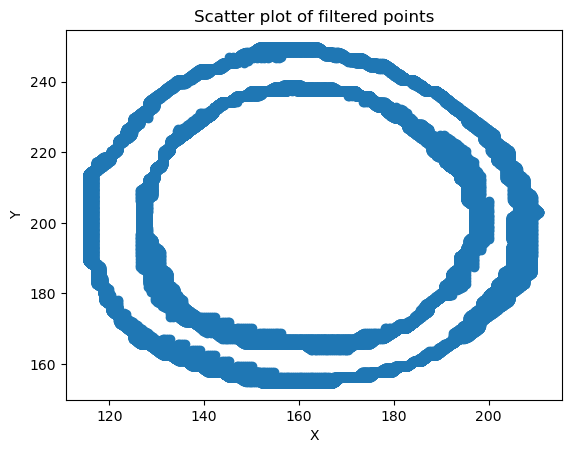

In [25]:
points = surface.points
filtered_points = points[(points[:, 2] >= 22) & (points[:, 2] <= 40), :2]
result_array = filtered_points
# Scatter plot of the filtered points
plt.scatter(result_array[:, 0], result_array[:, 1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter plot of filtered points')
plt.show()

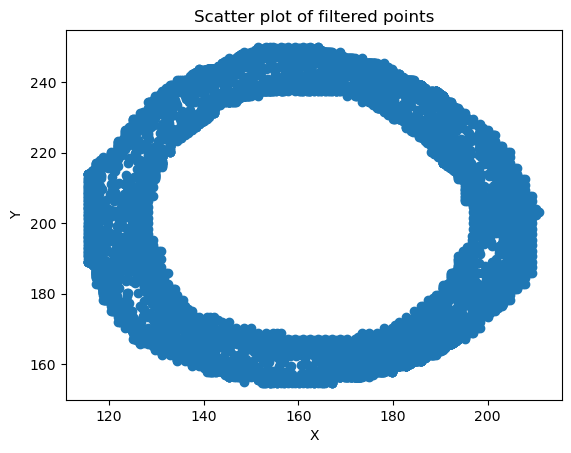

In [26]:
points = volume.points
filtered_points = points[(points[:, 2] >= 22) & (points[:, 2] <= 40), :2]
result_array = filtered_points
# Scatter plot of the filtered points
plt.scatter(result_array[:, 0], result_array[:, 1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter plot of filtered points')
plt.show()

In [27]:
#volume.save(f'ACDC_raw/database/training/patient{patient_no}/patient{patient_no}_vol.vtk')


In [28]:
#surface.save(f'ACDC_raw/database/training/patient{patient_no}/patient{patient_no}_surf_vol.vtk')

In [29]:
# Mesh coords of image voxels and segmentation nodes
im_mesh, segm_mesh = im_and_segm_mesh(imt_data, crop_x_in, crop_x_end, crop_y_in, crop_y_end, data_path)

In [30]:
# Mesh coords for background nodes
bg_mesh_file = os.path.join(data_path, 'background_points_'+crop_str+'.npy')
bg_mesh = background_mesh(data_path, imt_data, crop_x_in, crop_x_end, crop_y_in, crop_y_end, bg_mesh_file, slices)

In [31]:
# Boolean mask: 1 if the voxel is in the LV, 0 otherwise
bool_mask_file = os.path.join(data_path, 'boolean_mask_'+crop_str+'.npy')
bool_mask = boolean_mask(data_path, imt_data, crop_x_in, crop_x_end, crop_y_in, crop_y_end, bool_mask_file )

In [32]:
os.getenv('OMP_NUM_THREADS')

'8'

In [33]:
### Neural Network ###

# Layers for u1, u2 and u3
neu = 2**6
layers_u = [4, neu, neu, neu, neu, neu, 3]

reg_mask = 1
lmbmu = 10**5
mu_NeoHook = 1e-5

# Number of iterations desired for the registration from t_1 to t_i
It = 1000             #I CHANGED the iterations for 300000 to 30000 to 1000
batch_size = 1000
# Number of points in LV used to calculate the Neo Hookean by minibatch
N_nodes = len(segm_mesh)
# Number of epochs 
nEpoch = int( np.ceil(It * batch_size / N_nodes) )

pix_crop = [pixsp_x, pixsp_y, pixsp_z, crop_x_in, crop_y_in]

In [34]:
print('thread #')
print(tf.config.threading.get_inter_op_parallelism_threads())
print(tf.config.threading.get_intra_op_parallelism_threads())

model = WarpPINN(imr, imt, layers_u, bool_mask, im_mesh, segm_mesh, bg_mesh, lmbmu, pix_crop, reg_mask)

print('# of epics: ' + str(nEpoch))

thread #
0
0
Constructing Neural Network...
Device mapping: no known devices.
random_normal/RandomStandardNormal: (RandomStandardNormal): /job:localhost/replica:0/task:0/device:CPU:0
random_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
random_normal: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
W_u_0/IsInitialized/VarIsInitializedOp: (VarIsInitializedOp): /job:localhost/replica:0/task:0/device:CPU:0
W_u_0/Assign: (AssignVariableOp): /job:localhost/replica:0/task:0/device:CPU:0
W_u_0/Read/ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:CPU:0
b_u_0/IsInitialized/VarIsInitializedOp: (VarIsInitializedOp): /job:localhost/replica:0/task:0/device:CPU:0
b_u_0/Assign: (AssignVariableOp): /job:localhost/replica:0/task:0/device:CPU:0
b_u_0/Read/ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:CPU:0
random_normal_1/RandomStandardNormal: (RandomStandardNormal): /job:l

In [35]:
print('thread #')
print(tf.config.threading.get_inter_op_parallelism_threads())
print(tf.config.threading.get_intra_op_parallelism_threads())
t0 = time.time()
tol_pretrain = 1e-6
model.pretrain(tol_pretrain)
t1 = time.time()

thread #
0
0
task:0/device:CPU:0
save/SaveV2/shape_and_slices: (Const): /job:localhost/replica:0/task:0/device:CPU:0
save/RestoreV2/tensor_names: (Const): /job:localhost/replica:0/task:0/device:CPU:0
save/RestoreV2/shape_and_slices: (Const): /job:localhost/replica:0/task:0/device:CPU:0
random_normal/RandomStandardNormal: (RandomStandardNormal): /job:localhost/replica:0/task:0/device:CPU:0
random_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
random_normal: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
W_u_0: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
W_u_0/IsInitialized/VarIsInitializedOp: (VarIsInitializedOp): /job:localhost/replica:0/task:0/device:CPU:0
W_u_0/Assign: (AssignVariableOp): /job:localhost/replica:0/task:0/device:CPU:0
W_u_0/Read/ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:CPU:0
b_u_0: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
b

In [36]:
es_imt_path = glob.glob(f'{data_path}/*frame1*_gt.nii*')[0]
es_imt_data = nib.load(es_imt_path)
es_imt = es_imt_data.get_fdata()
es_imt = np.transpose(es_imt, [2, 1, 0])

es_frame_no = int(es_imt_path[54:56])

low = 1.5 #
high = 3
es_mask = np.zeros(es_imt.shape)
es_mask[(es_imt > low) & (es_imt < high)] = 1
es_mask = es_mask[:, crop_y_in:crop_y_end, crop_x_in:crop_x_end].astype(np.float32)

_names: (Const): /job:localhost/replica:0/task:0/device:CPU:0
save/SaveV2/shape_and_slices: (Const): /job:localhost/replica:0/task:0/device:CPU:0
save/RestoreV2/tensor_names: (Const): /job:localhost/replica:0/task:0/device:CPU:0
save/RestoreV2/shape_and_slices: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Const_4: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_10/Shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_10/grad_ys_0/Const: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_10/Mean_4_grad/Reshape/shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_10/Mean_4_grad/Shape_2: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_10/Mean_4_grad/Const: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_10/Mean_4_grad/Const_1: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_10/Mean_4_grad/Maximum/y: (Const): /job:localhost/replica:0/task:0/device:CPU:0
gradients_10/Squa

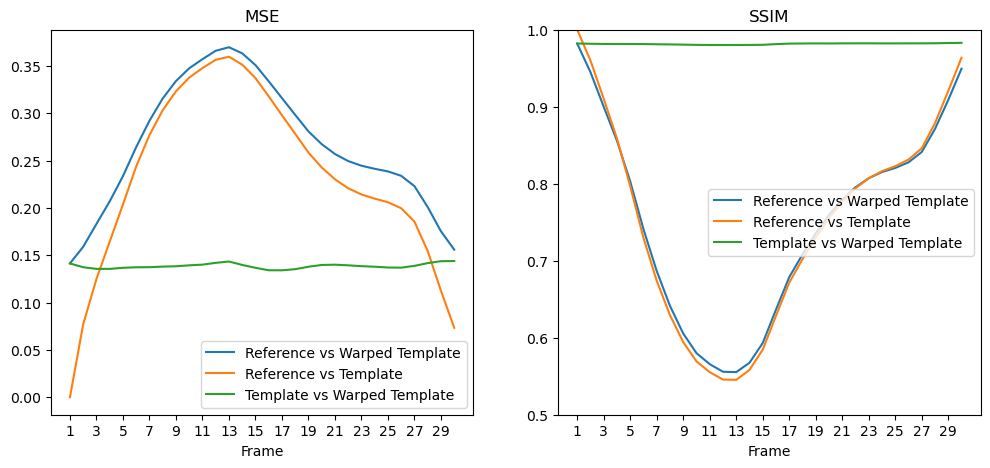

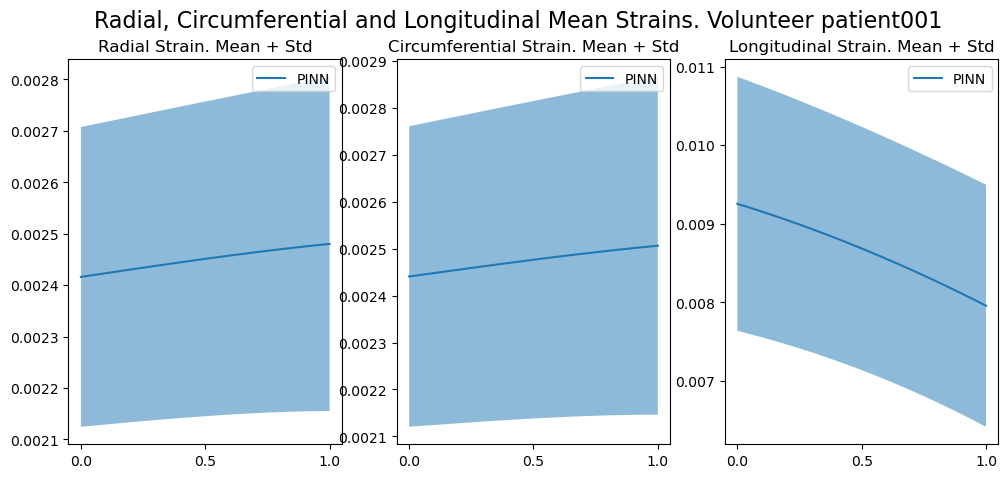

In [37]:
# An exception may occur during backpropagation if J = 0 at some point.

try:
    # Choose either L1 norm or L2 norm to measure the difference between reference and warped template images

    model.train_Adam_L1_NeoHook(nEpoch, mu_NeoHook, size=batch_size)
    #model.train_Adam_MSE_NeoHook(nEpoch, mu_NeoHook, size=batch_size) 

except:
    
    print('J = 0 at some point. Training has stopped. Predictions are made from last iteration.')

finally:

    ### Save model ###

    str_neu = str(neu)
    str_mask = str(reg_mask)
    str_batch = str(batch_size)

    str_mu_NeoHook = str(mu_NeoHook)
    str_lmbmu = str(lmbmu)

    model_name = 'model_L1_'+str_mu_NeoHook+'_NH_lmbmu_'+str_lmbmu+'_mask_'+str_mask+'_neu_'+str_neu+'_batch_'+str_batch
    # model_name = 'model_L2_'+str_mu_NeoHook+'_NH_lmbmu_'+str_lmbmu+'_mask_'+str_mask+'_neu_'+str_neu+'_batch_'+str_batch

    model_dir = os.path.join( 'results', 'L1', patient, model_name) 
    #model_dir = os.path.join( 'results', 'L2', volunteer, model_name) 

    model_save = os.path.join(model_dir, model_name)

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model.saver.save(model.sess, model_save)

    t2 = time.time()    

    ### Loading data for post-processing ###

    # Mesh coords of nodes in the ventricle to be deformed to simulate heart beating
    surf_mesh = meshio.read( os.path.join( data_path, patient +'_surf_vol.vtk' ))

    
    # Ground truth landmarks. Get landmarks at first frame from observer 1 (in the first frame they are the same for observer 2)
    #gt_inria_lmks_path = os.path.join(data_path, 'LMKS_GT/INRIA_COORDINATES')
    #gt_obs1 = os.path.join(gt_inria_lmks_path, 'obs1_groundTruth00.vtk')
    #lmks_gt_obs1 = read_lmks_mesh(gt_obs1)

    # For strains

    # Mesh coords
    origin = np.mean(surf_mesh.points, axis = 0)
    cart_coords = surf_mesh.points - origin
    angle = np.arctan2(cart_coords[:,1], cart_coords[:,0])

    rho = np.hstack((np.cos(angle)[:,None], np.sin(angle)[:,None]))
    theta = np.hstack((-np.sin(angle)[:,None], np.cos(angle)[:,None]))

    rho_1 = np.reshape(rho, [-1,1,2])
    rho_2 = np.reshape(rho, [-1,2,1])

    theta_1 = np.reshape(theta, [-1,1,2])
    theta_2 = np.reshape(theta, [-1,2,1])

    # Surface at first frame
    surf_path = os.path.join(model_dir, 'surfaces')
    if not os.path.exists(surf_path):
        os.makedirs( surf_path )

    num_nodes = len(surf_mesh.points)

    file_name = os.path.join(surf_path, 'p001_surf.vtk')
    meshio.write(file_name, meshio.Mesh(points=surf_mesh.points, cells = {'triangle': surf_mesh.cells_dict['triangle']}, \
                    point_data = {'radStrain':np.zeros([num_nodes]), 'circStrain':np.zeros([num_nodes]), 'longStrain': np.zeros([num_nodes]), 'Jacobian': np.ones([num_nodes])}))

    # Landmarks at first frame
    lmks_path = os.path.join(model_dir, 'lmks')
    if not os.path.exists( lmks_path ):
        os.makedirs( lmks_path )

    #file_name = os.path.join( lmks_path, 'lmks_results{0}.vtk'.format(0))
    #meshio.write(file_name, meshio.Mesh(points=lmks_gt_obs1, cells={}))

    # To generate some basic plots for Reference image vs Predicted image
    mse_pred_list = []
    ssim_pred_list = []
    dice_pred_list = []

    # To generate some basic plots for Reference image vs Template image
    mse_temp_list = []
    ssim_temp_list = []
    dice_temp_list = []
    
     # To generate some basic plots for Template image vs Warped image
    mse_wartemp_list = []
    ssim_wartemp_list = []
    dice_wartemp_list = []
    
    #TESTING DICE SCORE
    def dice_score(true, pred):
        intersection = np.logical_and(true, pred).sum()
        total_pixels = np.size(true) + np.size(pred)
        dice = (2.0 * intersection) / total_pixels if total_pixels != 0 else 0.0
        return dice

    # To generate some basic plots for strains
    # Radial
    mean_rr = np.zeros([frames])
    median_rr = np.zeros([frames])
    std_rr = np.zeros([frames])
    # Circumferential
    mean_cc = np.zeros([frames])
    median_cc = np.zeros([frames])
    std_cc = np.zeros([frames])
    # Longitudinal
    mean_ll = np.zeros([frames])
    median_ll = np.zeros([frames])
    std_ll = np.zeros([frames])
    
    imt_resc2 = np.zeros(np.shape(imt))
    imt_pred2 = np.zeros(np.shape(imt))
    
    d1 = []
    d2 = []
    d3 = []

    # Warping at different times

    for i in range(frames):

        # Surface warp
        surf_mesh_warp, u1, u2, u3, u1x, u1y, u1z, u2x, u2y, u2z, u3x, u3y, u3z, J = model.surface_deformation(surface.points, i)

        grad_um = np.hstack((u1x, u1y, u1z, u2x, u2y, u2z, u3x, u3y, u3z))
        grad_um = np.reshape(grad_um, [-1, 3, 3])
        grad_um_t = np.transpose(grad_um, [0, 2, 1])

        Em = 1/2 * (grad_um + grad_um_t + np.matmul(grad_um_t, grad_um))

        Em_new = Em[:,0:2,0:2]
        # Radial strain
        Em_rr = np.matmul(rho_1, np.matmul(Em_new, rho_2))
        # Circumferential strain
        Em_cc = np.matmul(theta_1, np.matmul(Em_new, theta_2))
        # Longitudinal strain
        Em_ll = Em[:,2,2]

        mean_rr[i] = np.mean(Em_rr)
        median_rr[i] = np.median(Em_rr)
        std_rr[i] = np.std(Em_rr)

        mean_cc[i] = np.mean(Em_cc)
        median_cc[i] = np.median(Em_cc)
        std_cc[i] = np.std(Em_cc)

        mean_ll[i] = np.mean(Em_ll)
        median_ll[i] = np.median(Em_ll)
        std_ll[i] = np.std(Em_ll)

        # Save warped surface with strains and jacobian
        file_name = os.path.join(surf_path, 'p{0}_surf.vtk'.format(i+1))
        meshio.write(file_name, meshio.Mesh(points=surf_mesh_warp, cells = {'triangle': surf_mesh.cells_dict['triangle']}, \
                    point_data = {'radStrain':Em_rr, 'circStrain':Em_cc, 'longStrain':Em_ll, 'Jacobian': J}))
        
        
        # Save warped Landmarks 
        #lmks_warp_obs1_mesh = model.lmks_deformation(lmks_gt_obs1, i)
        #file_name = os.path.join(lmks_path, 'lmks_results{0}.vtk'.format(i+1))
        #meshio.write(file_name, meshio.Mesh(points=lmks_warp_obs1_mesh, cells={}))

        # Prediction on voxel coordinates

        imr_pred, u1_pred, u2_pred, u3_pred, u1x_pred, u1y_pred, u1z_pred, u2x_pred, u2y_pred, u2z_pred, u3x_pred, u3y_pred, u3z_pred, J_pred = model.predict(i)
        
        d1.append(u1_pred)
        d2.append(u2_pred)
        d3.append(u3_pred)

        imt_i = imt[i,:,:,:]
        ub_im = np.max([np.max(imr), np.max(imt)])
        lb_im = np.min([np.min(imr), np.min(imt)])
        imr_resc = (imr - lb_im) / (ub_im - lb_im)
        imt_resc = (imt_i - lb_im) / (ub_im - lb_im)

        # Comparing predicted image and reference image
        print('Reference image vs predicted image frame {0}'.format(i))
        compare_images(imr_resc[1:-1], imr_pred[1:-1])
        print('Reference image vs Template image frame {0}'.format(i))
        compare_images(imr_resc[1:-1], imt_resc[1:-1])

        mse_pred_list.append( np.sqrt((np.square(imr_resc[1:-1]-imr_pred[1:-1])).mean() / (np.square(imr_resc[1:-1])).mean()) )
        mse_temp_list.append( np.sqrt((np.square(imr_resc[1:-1]-imt_resc[1:-1])).mean() / (np.square(imr_resc[1:-1])).mean()) )
        mse_wartemp_list.append( np.sqrt((np.square(imt_resc[1:-1]-imr_pred[1:-1])).mean() / (np.square(imr_resc[1:-1])).mean()) )
        
        ssim_pred_list.append( ssim(imr_resc[1:-1], imr_pred[1:-1], data_range=imr_resc[1:-1].max() - imr_resc[1:-1].min())) #added data range to ssim method
        ssim_temp_list.append( ssim(imr_resc[1:-1], imt_resc[1:-1], data_range=imr_resc[1:-1].max() - imr_resc[1:-1].min())) #added data range to ssim method
        ssim_wartemp_list.append( ssim(imt_resc[1:-1], imr_pred[1:-1], data_range=imr_resc[1:-1].max() - imr_resc[1:-1].min())) 
        
        dice_pred_list.append( dice_score(imr_resc[1:-1], imr_pred[1:-1]))
        dice_temp_list.append( dice_score(imr_resc[1:-1], imt_resc[1:-1]))
        dice_wartemp_list.append( dice_score(imt_resc[1:-1], imr_pred[1:-1]))
        
        imt_resc2[i,:,:,:] = imt_resc
        imt_pred2[i,:,:,:] = imr_pred

    np.save( os.path.join(model_dir, 'mse_pred_list.npy'), np.array(mse_pred_list))
    np.save( os.path.join(model_dir, 'ssim_pred_list.npy'), np.array(ssim_pred_list))
    np.save( os.path.join(model_dir, 'mse_temp_list.npy'), np.array(mse_temp_list))
    np.save( os.path.join(model_dir, 'ssim_temp_list.npy'), np.array(ssim_temp_list))

    np.save( os.path.join(model_dir, 'loss_registration.npy'), np.array(model.lossit_MSE))
    np.save( os.path.join(model_dir, 'loss_nh.npy'), np.array(model.lossit_NeoHook))
    np.save( os.path.join(model_dir, 'loss.npy'), np.array(model.lossit_value))

    # Generate plots of MSE and SSIM
    mse_ssim(model_dir, frames, mse_pred_list, mse_temp_list, mse_wartemp_list, ssim_pred_list, ssim_temp_list, ssim_wartemp_list)

    # Generate strain graphs
    pinn_strains = np.vstack([mean_rr, median_rr, std_rr, mean_cc, median_cc, std_cc, mean_ll, median_ll, std_ll ])
    global_strain(data_path, model_dir, frames, pinn_strains)

    #box_plots(data_path, model_dir)
    

Frame 0

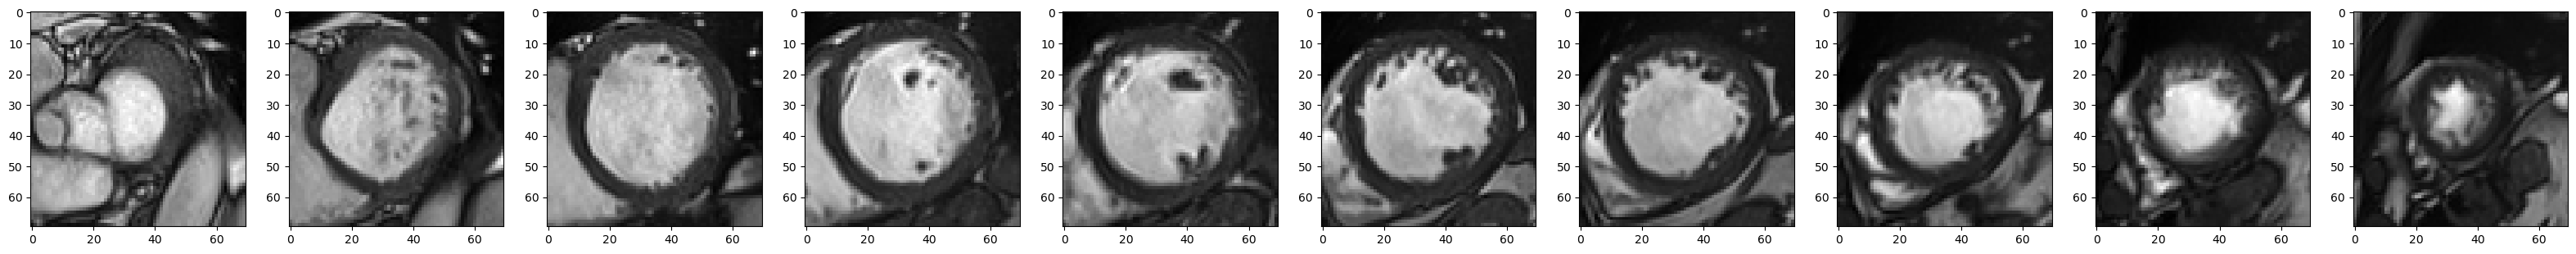

In [71]:
fig,ax = plt.subplots(1, 10, figsize=(40,40))
for i in range(10):
    ax[i].imshow(imr_resc[i, :, :], cmap='gray')

Prediction

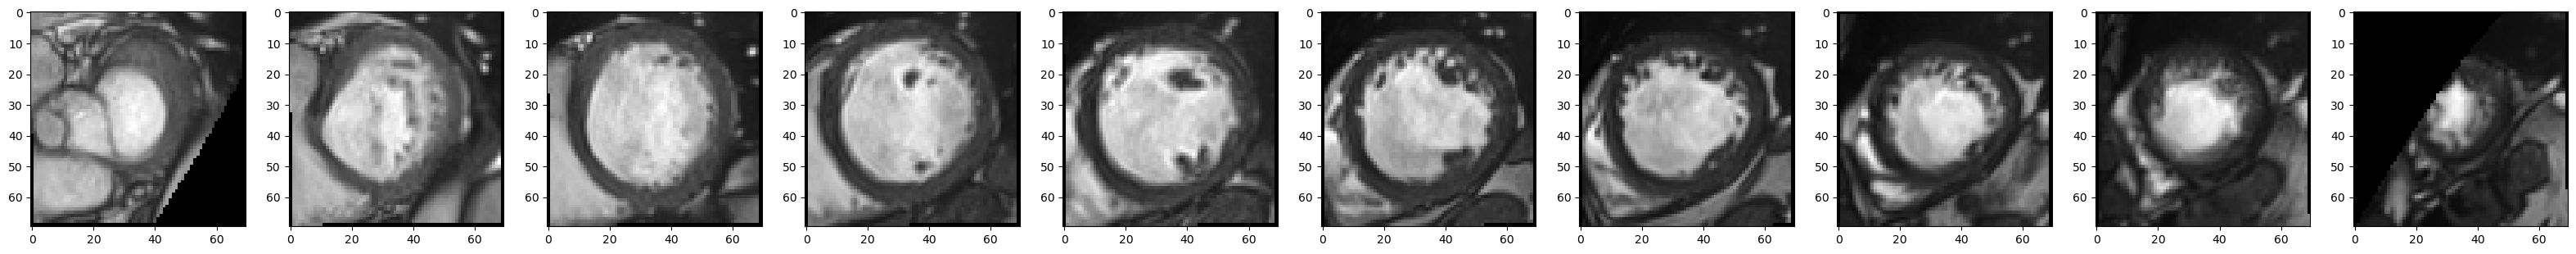

In [72]:
fig,ax = plt.subplots(1, 10, figsize=(40,40))
for i in range(10):
    ax[i].imshow(imr_pred[i, :, :], cmap='gray')

Difference between Reference and Prediction

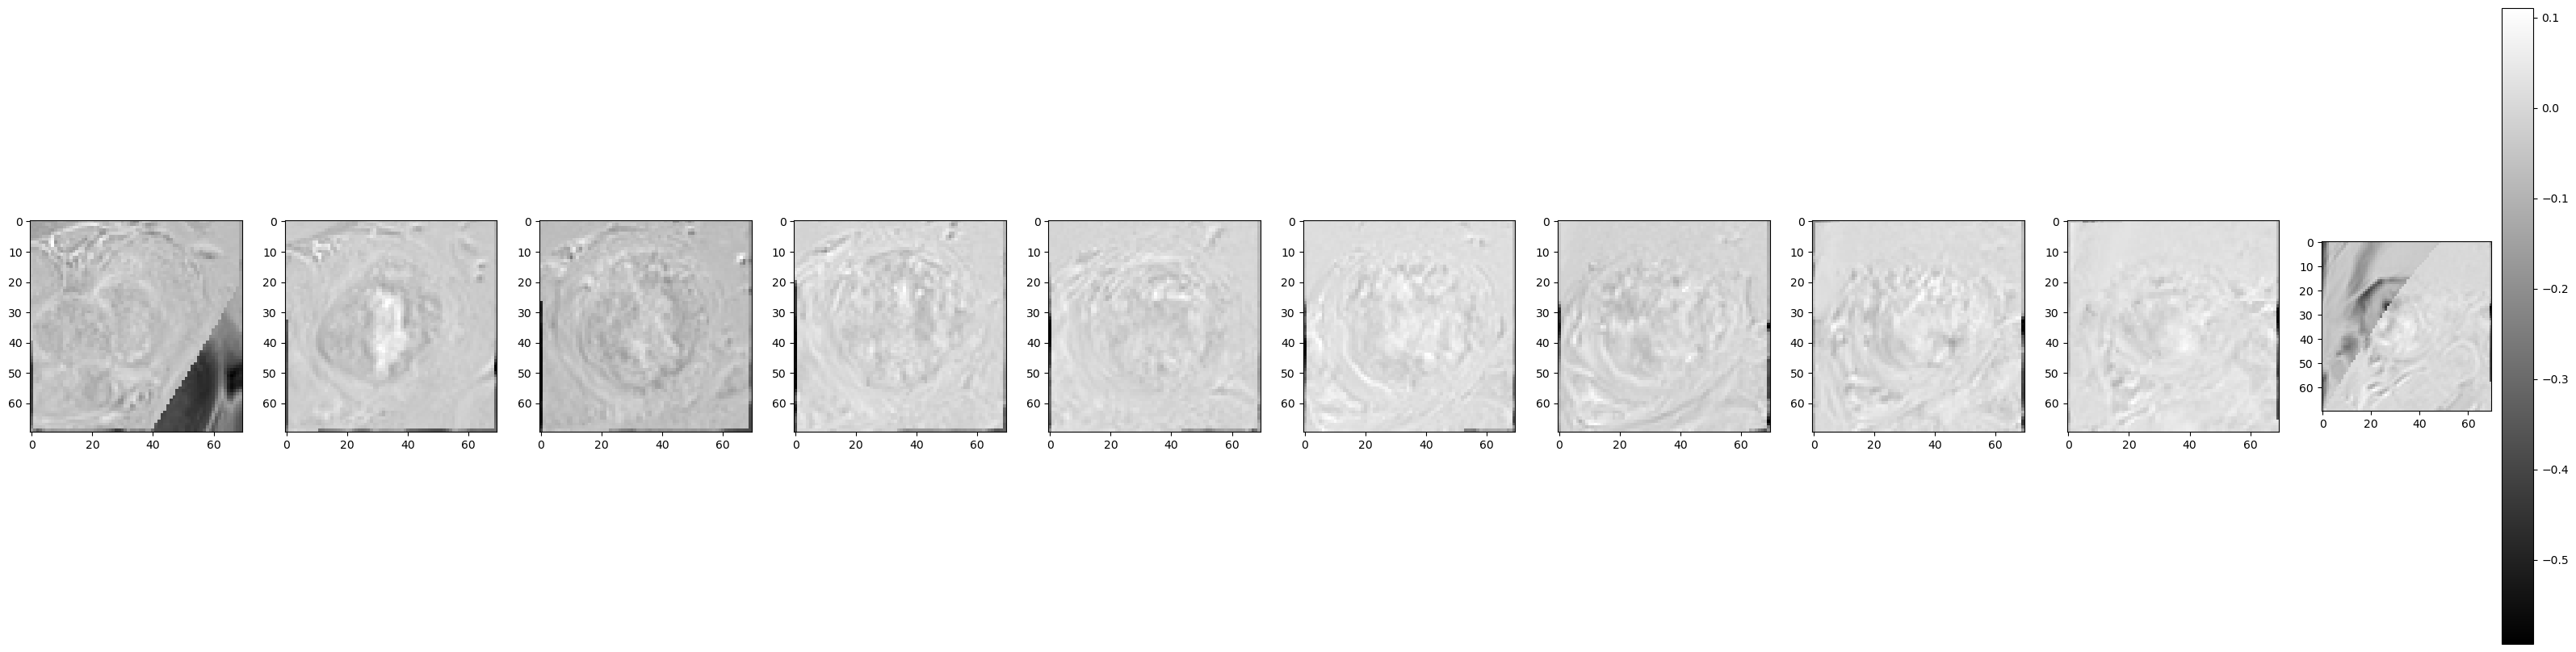

In [75]:
fig,ax = plt.subplots(1, 10, figsize=(40,40))
for i in range(10):
    im = ax[i].imshow(imr_pred[i, :, :] - imr_resc[i, :, :], cmap='gray')
fig.colorbar(im, ax=ax[i])

In [76]:
crop_mask = mask.transpose(2, 1, 0)
crop_mask = crop_mask[:, crop_y_in:crop_y_end, crop_x_in:crop_x_end].astype(np.float32)

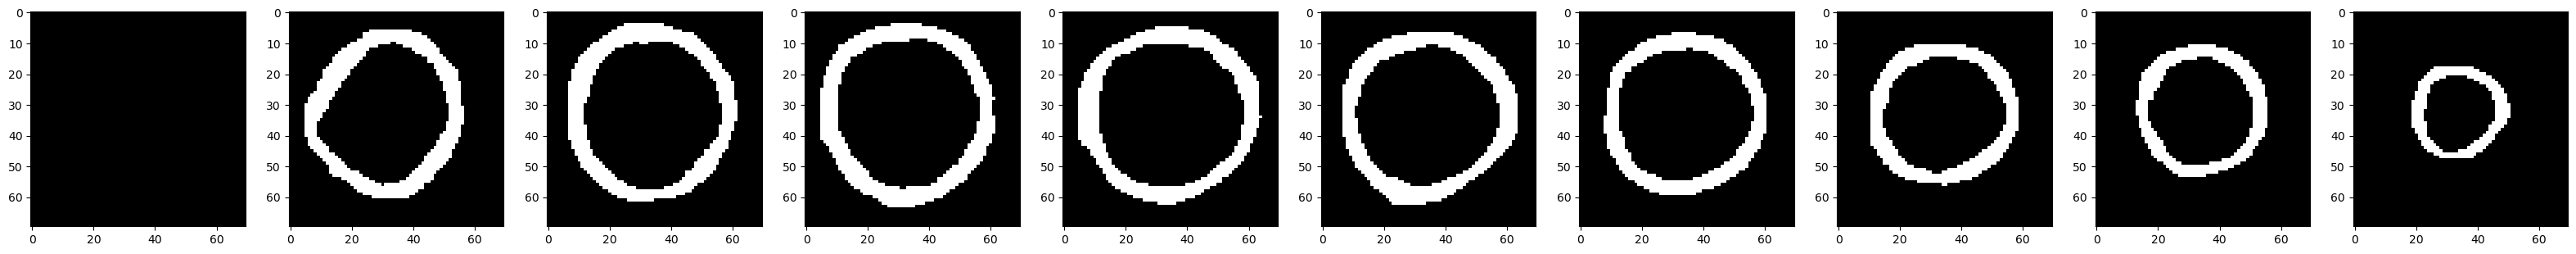

In [77]:
fig,ax = plt.subplots(1, slices, figsize=(40,40))
for i in range(slices):
    ax[i].imshow(crop_mask[i, :, :], cmap='gray')

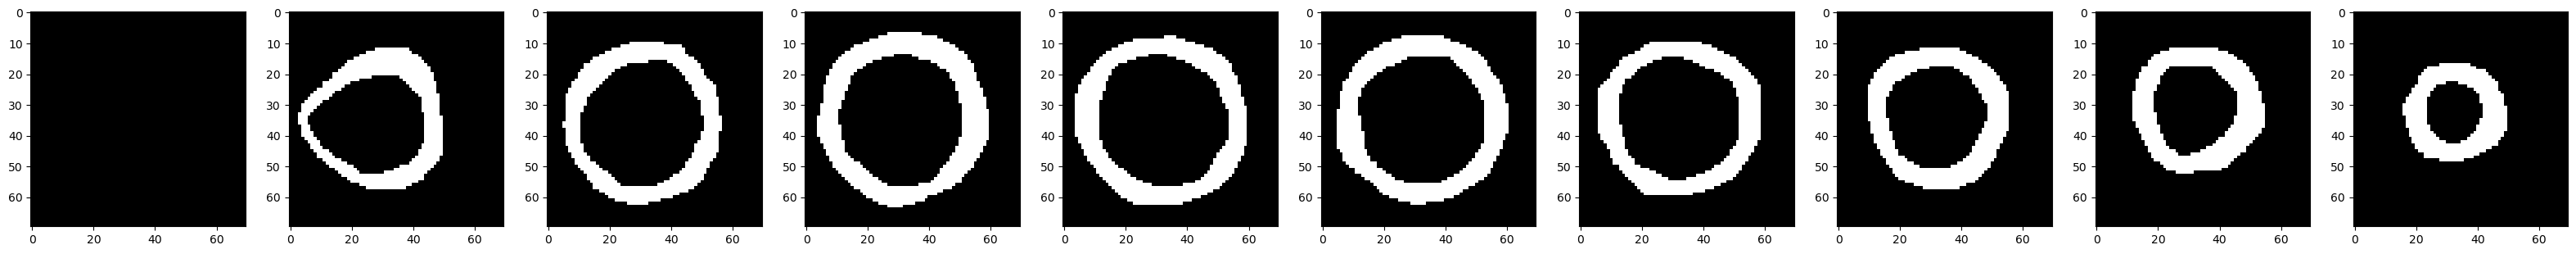

In [78]:
fig,ax = plt.subplots(1, slices, figsize=(40,40))
for i in range(slices):
    ax[i].imshow(es_mask[i, :, :], cmap='gray')

In [40]:
u1_pred_rs = d1[11].reshape(crop_mask.shape)
u2_pred_rs = d2[11].reshape(crop_mask.shape)
u3_pred_rs = d3[11].reshape(crop_mask.shape)

In [91]:
z_size, y_size, x_size = crop_mask.shape

coords = np.indices((z_size, y_size, x_size))

u1_pred_rs = d1[11].reshape(crop_mask.shape)
u2_pred_rs = d2[11].reshape(crop_mask.shape)
u3_pred_rs = d3[11].reshape(crop_mask.shape)

warped_x_coords = coords[2] + u1_pred_rs
warped_y_coords = coords[1] + u2_pred_rs
warped_z_coords = coords[0] + u3_pred_rs

warped_mask = map_coordinates(crop_mask, [warped_z_coords, warped_y_coords, warped_x_coords], order=1, mode='nearest')
warped_mask[warped_mask > 0] = 1

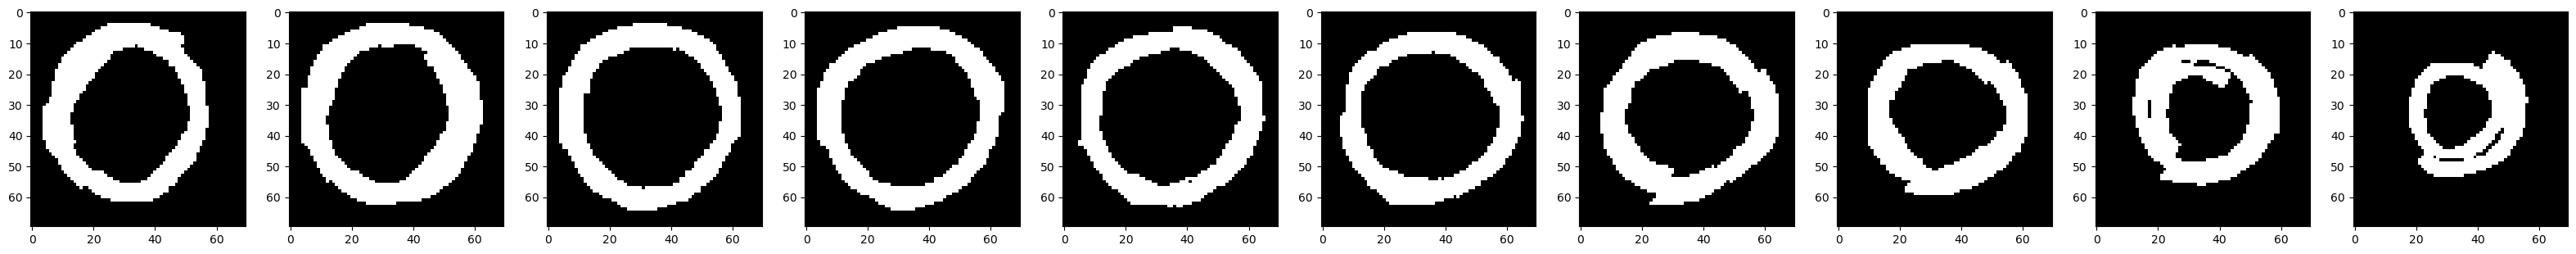

In [92]:
fig,ax = plt.subplots(1, slices, figsize=(40,40))
for i in range(slices):
    ax[i].imshow(warped_mask[i, :, :], cmap='gray')

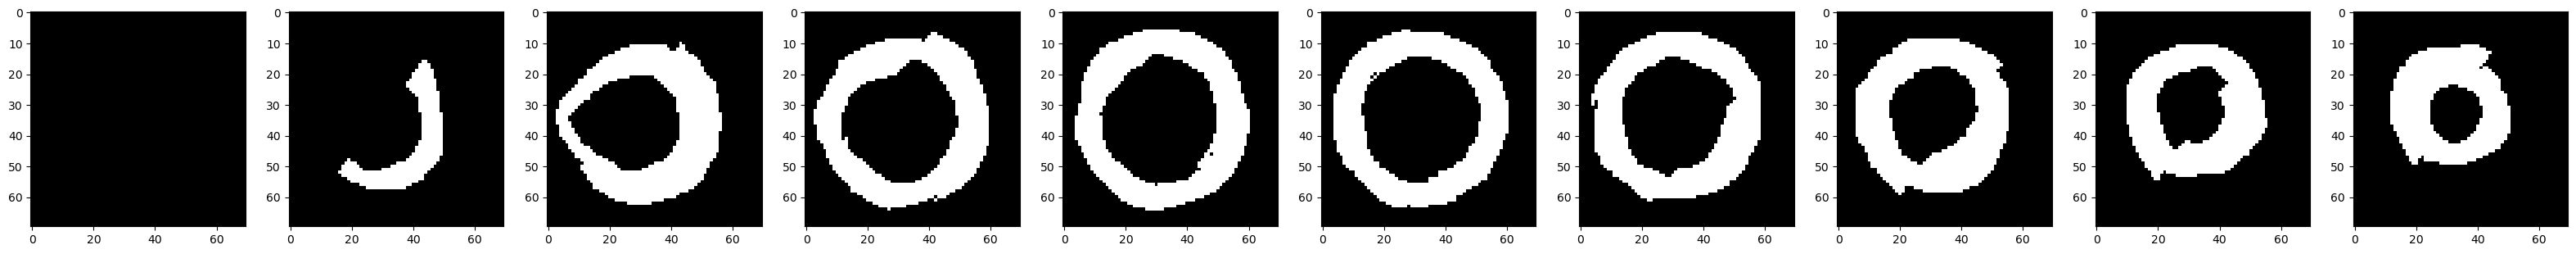

In [97]:
z_size, y_size, x_size = es_mask.shape

coords = np.indices((z_size, y_size, x_size))

u1_pred_rs = d1[11].reshape(es_mask.shape)
u2_pred_rs = d2[11].reshape(es_mask.shape)
u3_pred_rs = d3[11].reshape(es_mask.shape)

warped_x_coords = coords[2] - u1_pred_rs
warped_y_coords = coords[1] - u2_pred_rs
warped_z_coords = coords[0] - u3_pred_rs

#try bilinear instead of "nearest"
warped_mask_2 = map_coordinates(es_mask, [warped_z_coords, warped_y_coords, warped_x_coords], order=1, mode='nearest')
warped_mask_2[warped_mask_2 > 0] = 1

fig,ax = plt.subplots(1, slices, figsize=(40,40))
for i in range(slices):
    ax[i].imshow(warped_mask_2[i, :, :], cmap='gray')

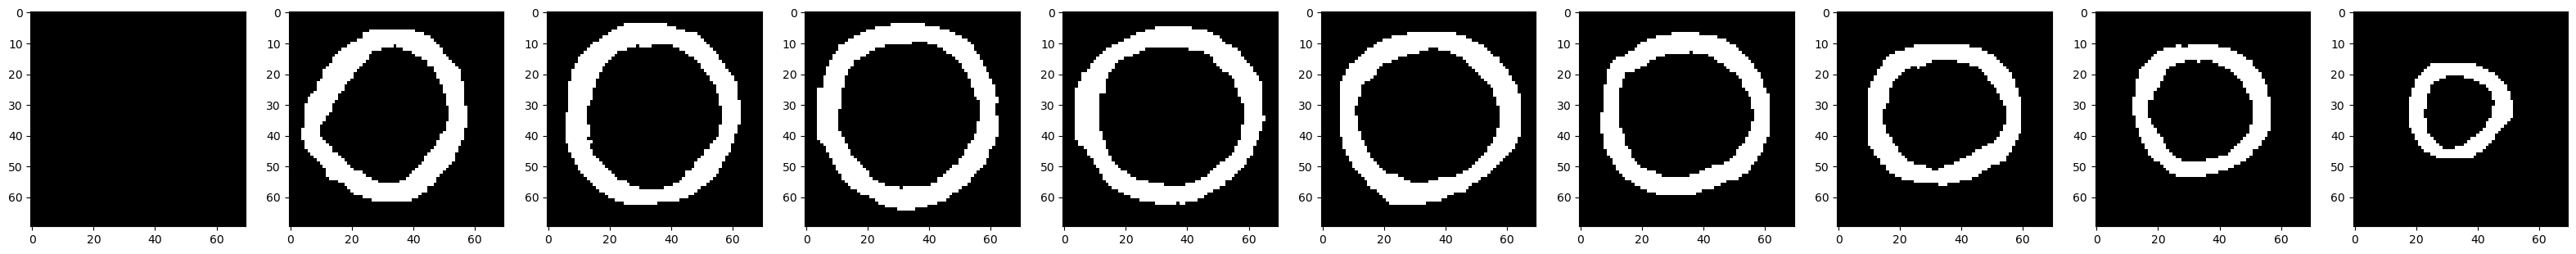

In [87]:
warped_masks = []
fig, ax = plt.subplots(1, 10, figsize=(40,40))

for i in range(10):
    gt = crop_mask[i, :, :]
    x = u1_pred.reshape(crop_mask.shape)[i]
    y = u2_pred.reshape(crop_mask.shape)[i]
    z = u3_pred.reshape(crop_mask.shape)[i]


    coords = np.indices(gt.shape)
    warped_x_coords = coords[1] + x
    warped_y_coords = coords[0] + y


    warped_mask = map_coordinates(gt, [warped_y_coords, warped_x_coords], order=1, mode='nearest')
    warped_mask[warped_mask > 0] = 1
    warped_masks.append(warped_mask)
    warped_masks_plus = warped_masks

    ax[i].imshow(warped_mask, cmap='gray')

plt.show()

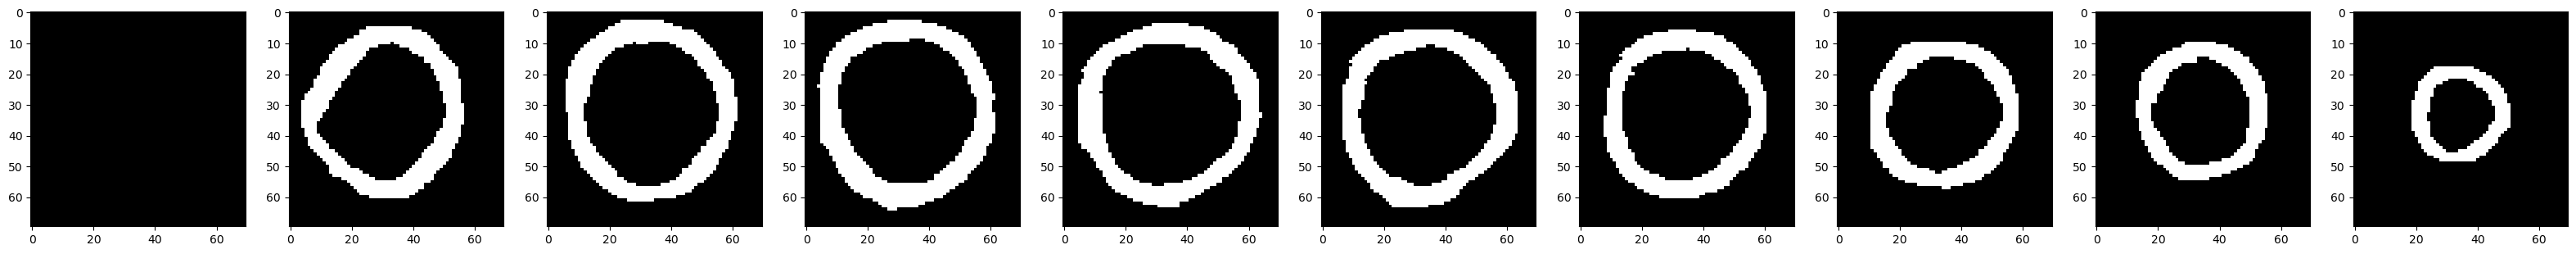

In [90]:
warped_masks = []
fig, ax = plt.subplots(1, 10, figsize=(40,40))

for i in range(10):
    gt = crop_mask[i, :, :]
    x = u1_pred.reshape(crop_mask.shape)[i]
    y = u2_pred.reshape(crop_mask.shape)[i]
    z = u3_pred.reshape(crop_mask.shape)[i]


    coords = np.indices(gt.shape)
    warped_x_coords = coords[1] - x
    warped_y_coords = coords[0] - y


    warped_mask = map_coordinates(gt, [warped_y_coords, warped_x_coords], order=1, mode='nearest')
    warped_mask[warped_mask > 0] = 1
    warped_masks.append(warped_mask)
    warped_masks_minus = warped_masks

    ax[i].imshow(warped_mask, cmap='gray')

plt.show()

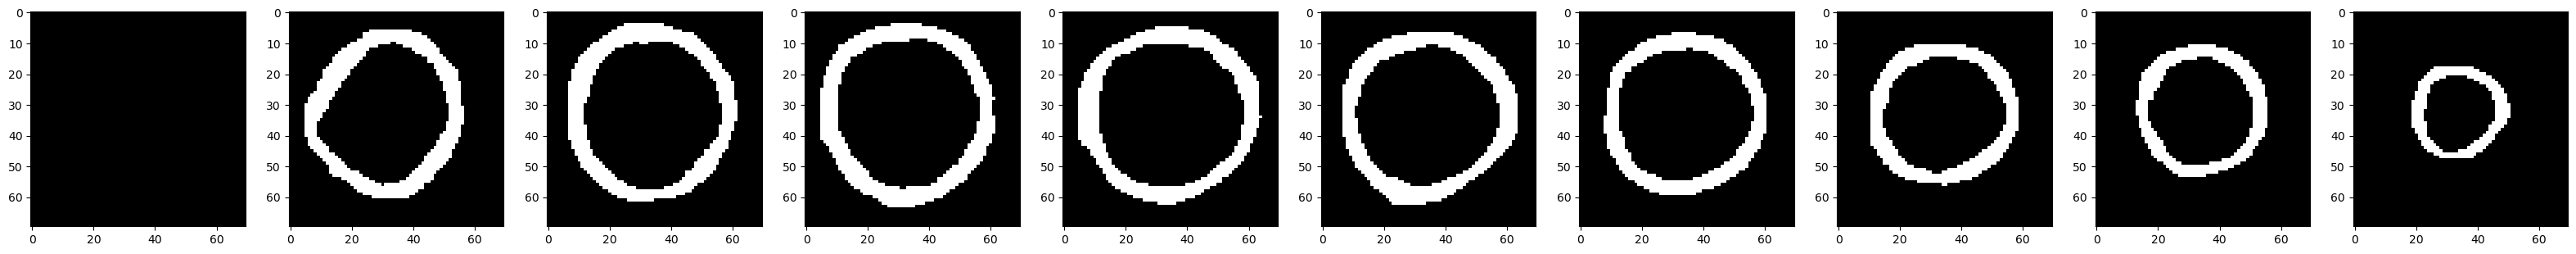

In [160]:
fig,ax = plt.subplots(1, 10, figsize=(40,40))
for i in range(10):
    im = ax[i].imshow(crop_mask[i, :, :], cmap='gray')

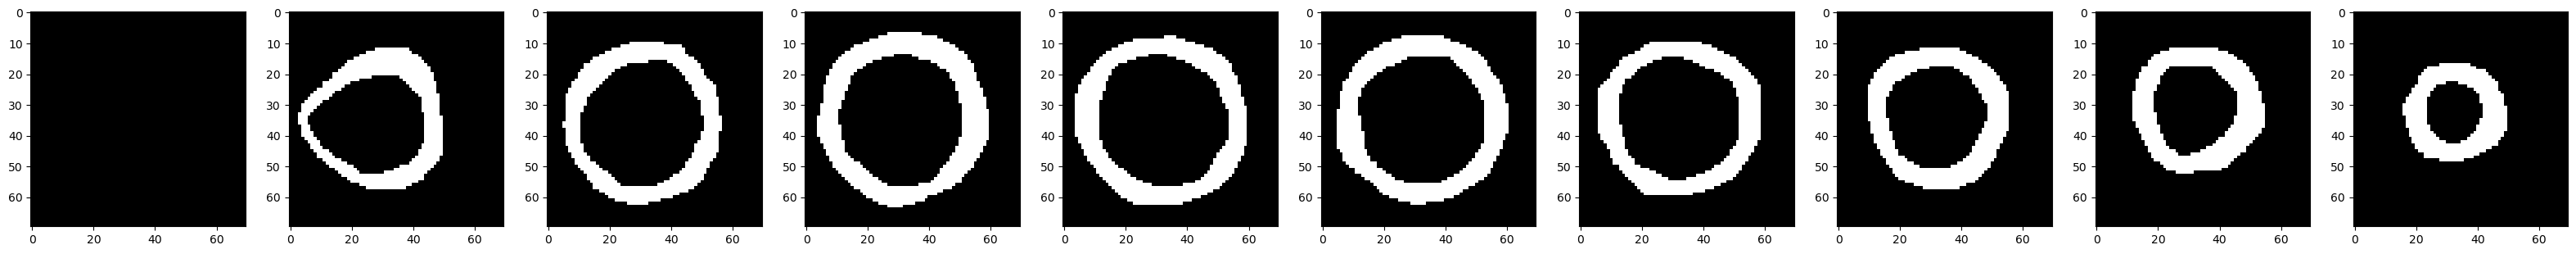

In [161]:
fig,ax = plt.subplots(1, 10, figsize=(40,40))
for i in range(10):
    im = ax[i].imshow(es_mask[i, :, :], cmap='gray')

In [59]:
from sklearn.metrics import f1_score

def dice_coefficient(im1, im2):
    im1 = np.asarray(im1).astype(np.bool_).flatten()
    im2 = np.asarray(im2).astype(np.bool_).flatten()

    return f1_score(im1, im2)

/rds/general/user/ag619/home/anaconda3/envs/PINNs_gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/rds/general/user/ag619/home/anaconda3/envs/PINNs_gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/rds/general/user/ag619/home/anaconda3/envs/PINNs_gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
 

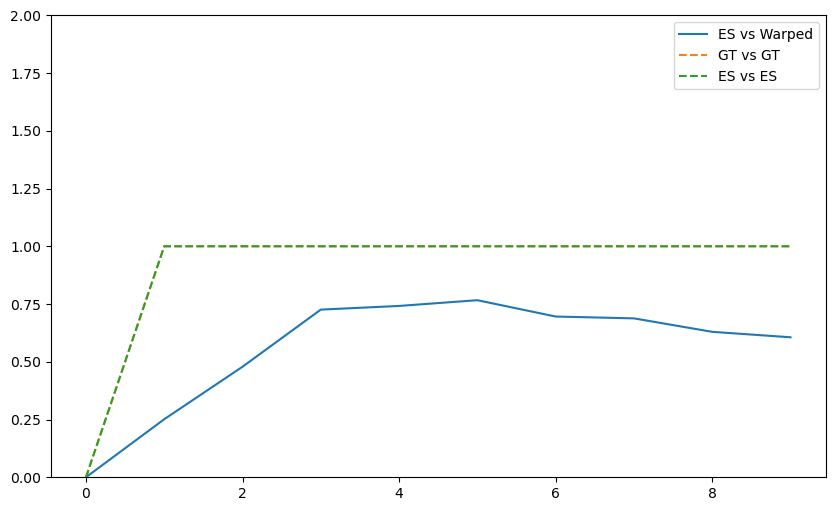

In [94]:
dice_scores_gt_es = []
dice_scores_gt_warped = []
dice_scores_es_warped = []
dice_scores_gt_gt = []
dice_scores_es_es = []

for i in range(10):
    gt = crop_mask[i, :, :]
    es = es_mask[i, :, :]
    warped = warped_mask[i]

    dice_score_gt_es = dice_coefficient(gt, es)
    dice_score_gt_warped = dice_coefficient(gt, warped)
    dice_score_es_warped = dice_coefficient(es, warped)
    dice_score_gt_gt = dice_coefficient(gt, gt)
    dice_score_es_es = dice_coefficient(es, es)

    dice_scores_gt_es.append(dice_score_gt_es)
    dice_scores_gt_warped.append(dice_score_gt_warped)
    dice_scores_es_warped.append(dice_score_es_warped)
    dice_scores_gt_gt.append(dice_score_gt_gt)
    dice_scores_es_es.append(dice_score_es_es)

# Plotting the scores
plt.figure(figsize=(10, 6))
#plt.plot(dice_scores_gt_es, label='GT vs ES')
#plt.plot(dice_scores_gt_warped, label='GT vs Warped')
plt.plot(dice_scores_es_warped, label='ES vs Warped')
plt.plot(dice_scores_gt_gt, label='GT vs GT', linestyle='--')
plt.plot(dice_scores_es_es, label='ES vs ES', linestyle='--')
plt.ylim([0,2])
plt.legend()
plt.show()

/rds/general/user/ag619/home/anaconda3/envs/PINNs_gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/rds/general/user/ag619/home/anaconda3/envs/PINNs_gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/rds/general/user/ag619/home/anaconda3/envs/PINNs_gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
 

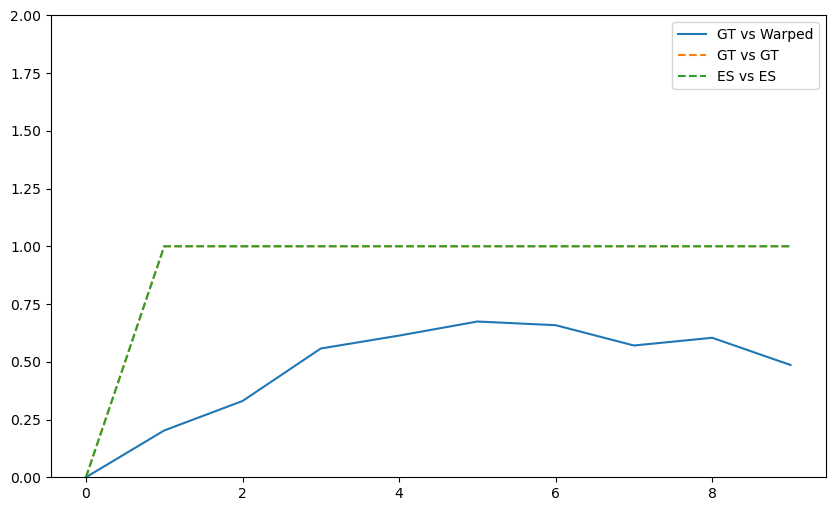

In [93]:
dice_scores_gt_es = []
dice_scores_gt_warped = []
dice_scores_es_warped = []
dice_scores_gt_gt = []
dice_scores_es_es = []

for i in range(10):
    gt = crop_mask[i, :, :]
    es = es_mask[i, :, :]
    warped = warped_mask_2[i]

    dice_score_gt_es = dice_coefficient(gt, es)
    dice_score_gt_warped = dice_coefficient(gt, warped)
    dice_score_es_warped = dice_coefficient(es, warped)
    dice_score_gt_gt = dice_coefficient(gt, gt)
    dice_score_es_es = dice_coefficient(es, es)

    dice_scores_gt_es.append(dice_score_gt_es)
    dice_scores_gt_warped.append(dice_score_gt_warped)
    dice_scores_es_warped.append(dice_score_es_warped)
    dice_scores_gt_gt.append(dice_score_gt_gt)
    dice_scores_es_es.append(dice_score_es_es)

# Plotting the scores
plt.figure(figsize=(10, 6))
#plt.plot(dice_scores_gt_es, label='GT vs ES')
plt.plot(dice_scores_gt_warped, label='GT vs Warped')
#plt.plot(dice_scores_es_warped, label='ES vs Warped')
plt.plot(dice_scores_gt_gt, label='GT vs GT', linestyle='--')
plt.plot(dice_scores_es_es, label='ES vs ES', linestyle='--')
plt.ylim([0,2])
plt.legend()
plt.show()